## Project 1: Predict the Housing Prices in Ames

#### [1. Introduction](#1)
##### [1.1. Input Data](#1.1)
#### [2. EDA](#)
#### [3. Results](#)

#### [x. References](#)
#### [x. Data Dictionary](#data_dict)

## <a id = '1'>1. Introduction<a/>

- The goal of this project is to predict the final price of a home (in log scale) using Ames housing dataset availalble on <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques">Kaggle</a>. This is primarily a regression problem.

- Two models will be built:
    1. using linear regression with Lasso or Ridge or Elasticnet penalty
    2. using tree based models such as random forest or boosting tree.

### <a id='1.1'> 1.1 Input Data<a/>

- There are 83 columns and 2930 row objects. Explaination of each column can be found in the [Data Dictionary](#data_dict).
    

In [222]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats import shapiro
import pylab

In [223]:
ames_data = pd.read_csv('Ames_data.csv')
ames_data.head()

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price
0,526301100,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Fence,None,0,5,2010,WD,Normal,-93.619754,42.054035,215000
1,526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,Minimum_Privacy,None,0,6,2010,WD,Normal,-93.619756,42.053014,105000
2,526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Fence,Gar2,12500,6,2010,WD,Normal,-93.619387,42.052659,172000
3,526353030,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Fence,None,0,4,2010,WD,Normal,-93.617320,42.051245,244000
4,527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,Minimum_Privacy,None,0,3,2010,WD,Normal,-93.638933,42.060899,189900


In [224]:
len(ames_data)

2930

### <a id='1.2'> 1.2 Test Ids<a/>
    
- There are 10 different test id list, each containing 879 objects

In [225]:
dat_file = 'project1_testIDs.dat'
test_ids = np.loadtxt(dat_file).T
test_ids.shape

(10, 879)

### <a id='1.3'> 1.3 Evaluation Metric<a/>
    
- To measure the performance of the regression models, root mean squared error is used as a performance metric.

> $$ \sqrt{\frac{1}{\text{n.test}} \sum_{j=1}^{\text{n.test}} (\hat{y}_j - y_j)^2}$$

## <a id = '1'>2. Data pre-processing<a/>

Taking a look at the data structure of input data.

In [229]:
def get_df_info(input_of):
    df_info = pd.DataFrame(columns=['column', 'Null Count', 'Data Type'])
    for col in input_of:
        Null_count  = sum(pd.isnull(input_of[col]))
        dtype = input_of[col].dtype
        df_info = df_info.append({'column': col, 'Null Count': Null_count, 'Data Type': dtype},
                                ignore_index = True)
    
    return df_info

df_info = get_df_info(ames_data)

In [230]:
df_info.head() # same as df.info()

,column,Null Count,Data Type
0,PID,0,int64
1,MS_SubClass,0,object
2,MS_Zoning,0,object
3,Lot_Frontage,0,int64
4,Lot_Area,0,int64


In [231]:
df_info[df_info['Data Type'] == 'int64']

,column,Null Count,Data Type
0,PID,0,int64
3,Lot_Frontage,0,int64
4,Lot_Area,0,int64
19,Year_Built,0,int64
20,Year_Remod_Add,0,int64
26,Mas_Vnr_Area,0,int64
34,BsmtFin_SF_1,0,int64
36,BsmtFin_SF_2,0,int64
37,Bsmt_Unf_SF,0,int64
38,Total_Bsmt_SF,0,int64


In [232]:
df_info[df_info['Data Type'] == 'object']

,column,Null Count,Data Type
1,MS_SubClass,0,object
2,MS_Zoning,0,object
5,Street,0,object
6,Alley,0,object
7,Lot_Shape,0,object
8,Land_Contour,0,object
9,Utilities,0,object
10,Lot_Config,0,object
11,Land_Slope,0,object
12,Neighborhood,0,object


In [233]:
df_info[df_info['Data Type'] == 'float64']

,column,Null Count,Data Type
59,Garage_Yr_Blt,159,float64
80,Longitude,0,float64
81,Latitude,0,float64


In [234]:
# ames_data.info()

There are 159 empty values for Garage_Yr_Blt. For now, we will keep them as it is.

In [235]:
ames_data.describe()

,PID,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,...,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Year_Sold,Longitude,Latitude,Sale_Price
count,2.930000e+03,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,7.144645e+08,57.647782,10147.921843,1971.356314,1984.266553,101.096928,4.177474,49.705461,559.071672,1051.255631,...,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,-93.642897,42.034482,180796.060068
std,1.887308e+08,33.499441,7880.017759,30.245361,20.860286,178.634545,2.233372,169.142089,439.540571,440.968018,...,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,0.025700,0.018410,79886.692357
min,5.263011e+08,0.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,-93.693153,41.986498,12789.000000
25%,5.284770e+08,43.000000,7440.250000,1954.000000,1965.000000,0.000000,3.000000,0.000000,219.000000,793.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,-93.660217,42.022088,129500.000000
50%,5.354536e+08,63.000000,9436.500000,1973.000000,1993.000000,0.000000,3.000000,0.000000,465.500000,990.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,-93.641806,42.034662,160000.000000
75%,9.071811e+08,78.000000,11555.250000,2001.000000,2004.000000,162.750000,7.000000,0.000000,801.750000,1301.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,-93.622113,42.049853,213500.000000
max,1.007100e+09,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,7.000000,1526.000000,2336.000000,6110.000000,...,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,-93.577427,42.063388,755000.000000


drop 3 outliers

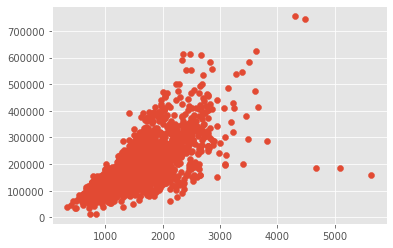

In [236]:
plt.scatter(ames_data.Gr_Liv_Area, ames_data.Sale_Price)
plt.show()

In [237]:
ames_data[ames_data.Gr_Liv_Area >  4500].index

Int64Index([1498, 2180, 2181], dtype='int64')

In [238]:
ames_data = ames_data.iloc[~ames_data.index.isin(ames_data[ames_data.Gr_Liv_Area >  4500].index), :]

### Convert Year values to age

In [239]:
ames_data[['Year_Remod_Add', 'Year_Built', 'Mo_Sold', 'Year_Sold']]

,Year_Remod_Add,Year_Built,Mo_Sold,Year_Sold
0,1960,1960,5,2010
1,1961,1961,6,2010
2,1958,1958,6,2010
3,1968,1968,4,2010
4,1998,1997,3,2010
...,...,...,...,...
2925,1984,1984,3,2006
2926,1983,1983,6,2006
2927,1992,1992,7,2006
2928,1975,1974,4,2006


In [240]:
ames_data[['Year_Remod_Add', 'Year_Built', 'Mo_Sold', 'Year_Sold']].describe()

,Year_Remod_Add,Year_Built,Mo_Sold,Year_Sold
count,2927.000000,2927.000000,2927.000000,2927.000000
mean,1984.241886,1971.319098,6.215237,2007.790912
std,20.856725,30.238491,2.712368,1.317120
min,1950.000000,1872.000000,1.000000,2006.000000
25%,1965.000000,1954.000000,4.000000,2007.000000
50%,1993.000000,1973.000000,6.000000,2008.000000
75%,2004.000000,2000.500000,8.000000,2009.000000
max,2010.000000,2010.000000,12.000000,2010.000000


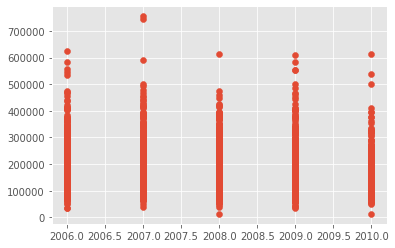

In [241]:
plt.style.use('ggplot')
plt.scatter(x = ames_data.Year_Sold, y = ames_data.Sale_Price)
plt.show()

In [242]:
yrBuilt = ames_data.groupby(['Year_Built']).mean()['Sale_Price']
yrRemod = ames_data.groupby(['Year_Remod_Add']).mean()['Sale_Price']

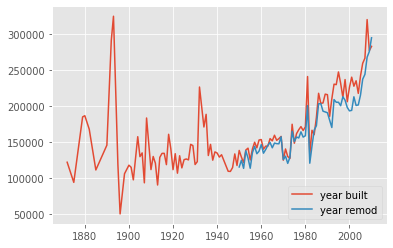

In [243]:
plt.plot(yrBuilt, label = 'year built')
plt.plot(yrRemod, label = 'year remod')
plt.legend()
plt.show()

>    - We can see that year sold does not have any correlation with sale price, hence lets drop it.

>    - We can also see year built and year remod have same mean sale price. Hence let's drop year remod and replace year built by age of the property.

In [244]:
ames_data.drop(['Year_Remod_Add', 'Mo_Sold', 'Year_Sold'], axis=1, inplace=True)
ames_data['Age_of_Property'] = 2010 - ames_data['Year_Built']
ames_data.drop(['Year_Built'], axis=1, inplace=True)

In [245]:
ames_data

,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Sale_Type,Sale_Condition,Longitude,Latitude,Sale_Price,Age_of_Property
0,526301100,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Pool,No_Fence,None,0,WD,Normal,-93.619754,42.054035,215000,50
1,526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Pool,Minimum_Privacy,None,0,WD,Normal,-93.619756,42.053014,105000,49
2,526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Pool,No_Fence,Gar2,12500,WD,Normal,-93.619387,42.052659,172000,52
3,526353030,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Pool,No_Fence,None,0,WD,Normal,-93.617320,42.051245,244000,42
4,527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Pool,Minimum_Privacy,None,0,WD,Normal,-93.638933,42.060899,189900,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,923275080,Split_or_Multilevel,Residential_Low_Density,37,7937,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,...,No_Pool,Good_Privacy,None,0,WD,Normal,-93.604776,41.988964,142500,26
2926,923276100,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0,8885,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,...,No_Pool,Minimum_Privacy,None,0,WD,Normal,-93.602680,41.988314,131000,27
2927,923400125,Split_Foyer,Residential_Low_Density,62,10441,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Pool,Minimum_Privacy,Shed,700,WD,Normal,-93.606847,41.986510,132000,18
2928,924100070,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77,10010,Pave,No_Alley_Access,Regular,Lvl,AllPub,...,No_Pool,No_Fence,None,0,WD,Normal,-93.600190,41.990921,170000,36


## <a id = '3'>3. EDA<a/>

### <a id='1.1'> 3.1 Categorical Variables Selection<a/>

In [246]:
df_info = get_df_info(ames_data)
categorical_vars = df_info[df_info['Data Type'] == 'object']
categorical_vars['Number of Categories'] = [len(ames_data[col].value_counts()) for col in categorical_vars.column]

In [247]:
categorical_vars

,column,Null Count,Data Type,Number of Categories
1,MS_SubClass,0,object,16
2,MS_Zoning,0,object,7
5,Street,0,object,2
6,Alley,0,object,3
7,Lot_Shape,0,object,4
8,Land_Contour,0,object,4
9,Utilities,0,object,3
10,Lot_Config,0,object,5
11,Land_Slope,0,object,3
12,Neighborhood,0,object,28


Lets visualize features that have less than 10 categories

In [248]:
cols = categorical_vars

In [249]:
# import plotly.express as px
# figures = []
# for col in categorical_vars.column:
#     fig = px.box(ames_data, x=col, y="Sale_Price", points="all", color = col)
#     figures.append(fig)

By looking at the boxplots, below categorical variable seem to provide variation that matches with sales price. Five stars provide max variance.

- Sale_Type *****
- Sale_Condition ****
- Paved_Drive ****
- Garage_Finish ****
- Garage_Type ****
- Fireplace_Qu ****
- Kitchen_Qual *****
- Central_Air *****
- Heating_QC ****
- Electrical ***
- Bsmt_Exposure ****
- Bsmt_Qual *****
- Foundation ***
- Exter_Qual *****
- Overall_Qual *****
- Condition_1 ***
- Neighborhood ****
- MS_Zoning ****
- MS_SubClass ***

In [250]:
# for fig in figures:
#     fig.show()

In [251]:
# fig = px.box(ames_data, x="Sale_Type", y="Sale_Price")
# fig.show()

In [252]:
# Selected Categorical Variables: 
selected_cat_col = ['Sale_Type', 'Fireplace_Qu', 'Kitchen_Qual', 'Central_Air', 'Heating_QC', 'Bsmt_Exposure', 
 'Bsmt_Qual', 'Exter_Qual', 'Overall_Qual', 'Neighborhood', 'MS_Zoning', 'Garage_Type', 'Sale_Condition', 
 'Paved_Drive', 'Garage_Finish', 'MS_SubClass', 'Electrical','Foundation', 'condition_1']

### <a id='1.1'> 3.1 Numerical Variables Selection<a/>

In [253]:
num_vars = df_info[df_info['Data Type'] != 'object']
num_vars.column

0                    PID
3           Lot_Frontage
4               Lot_Area
24          Mas_Vnr_Area
32          BsmtFin_SF_1
34          BsmtFin_SF_2
35           Bsmt_Unf_SF
36         Total_Bsmt_SF
41          First_Flr_SF
42         Second_Flr_SF
43       Low_Qual_Fin_SF
44           Gr_Liv_Area
45        Bsmt_Full_Bath
46        Bsmt_Half_Bath
47             Full_Bath
48             Half_Bath
49         Bedroom_AbvGr
50         Kitchen_AbvGr
52         TotRms_AbvGrd
54            Fireplaces
57         Garage_Yr_Blt
59           Garage_Cars
60           Garage_Area
64          Wood_Deck_SF
65         Open_Porch_SF
66        Enclosed_Porch
67    Three_season_porch
68          Screen_Porch
69             Pool_Area
73              Misc_Val
76             Longitude
77              Latitude
78            Sale_Price
79       Age_of_Property
Name: column, dtype: object

In [254]:
# We can drop PID since this won't affect Sale_Price
num_vars= num_vars.iloc[1:, :]
num_vars

,column,Null Count,Data Type
3,Lot_Frontage,0,int64
4,Lot_Area,0,int64
24,Mas_Vnr_Area,0,int64
32,BsmtFin_SF_1,0,int64
34,BsmtFin_SF_2,0,int64
35,Bsmt_Unf_SF,0,int64
36,Total_Bsmt_SF,0,int64
41,First_Flr_SF,0,int64
42,Second_Flr_SF,0,int64
43,Low_Qual_Fin_SF,0,int64


- We can eleminate variables using co-relation plot
> $$Corr(x, y) = {\displaystyle \rho _{X,Y}=\operatorname {corr} (X,Y)={\operatorname {cov} (X,Y) \over \sigma _{X}\sigma _{Y}}={\operatorname {E} [(X-\mu _{X})(Y-\mu _{Y})] \over \sigma _{X}\sigma _{Y}}}$$

Alternatively,
$$ Corr(x,y) = {\displaystyle \rho _{X,Y}={\operatorname {E} (XY)-\operatorname {E} (X)\operatorname {E} (Y) \over {\sqrt {\operatorname {E} (X^{2})-\operatorname {E} (X)^{2}}}\cdot {\sqrt {\operatorname {E} (Y^{2})-\operatorname {E} (Y)^{2}}}}}$$


Sample correlation coefficient(r) $$ r = {\frac {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sqrt {\sum \limits _{i=1}^{n}(x_{i}-{\bar {x}})^{2}\sum \limits _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}} $$


In [255]:
ames_num_cols_df = ames_data.loc[:, ames_data.columns.isin(num_vars.column.tolist())]

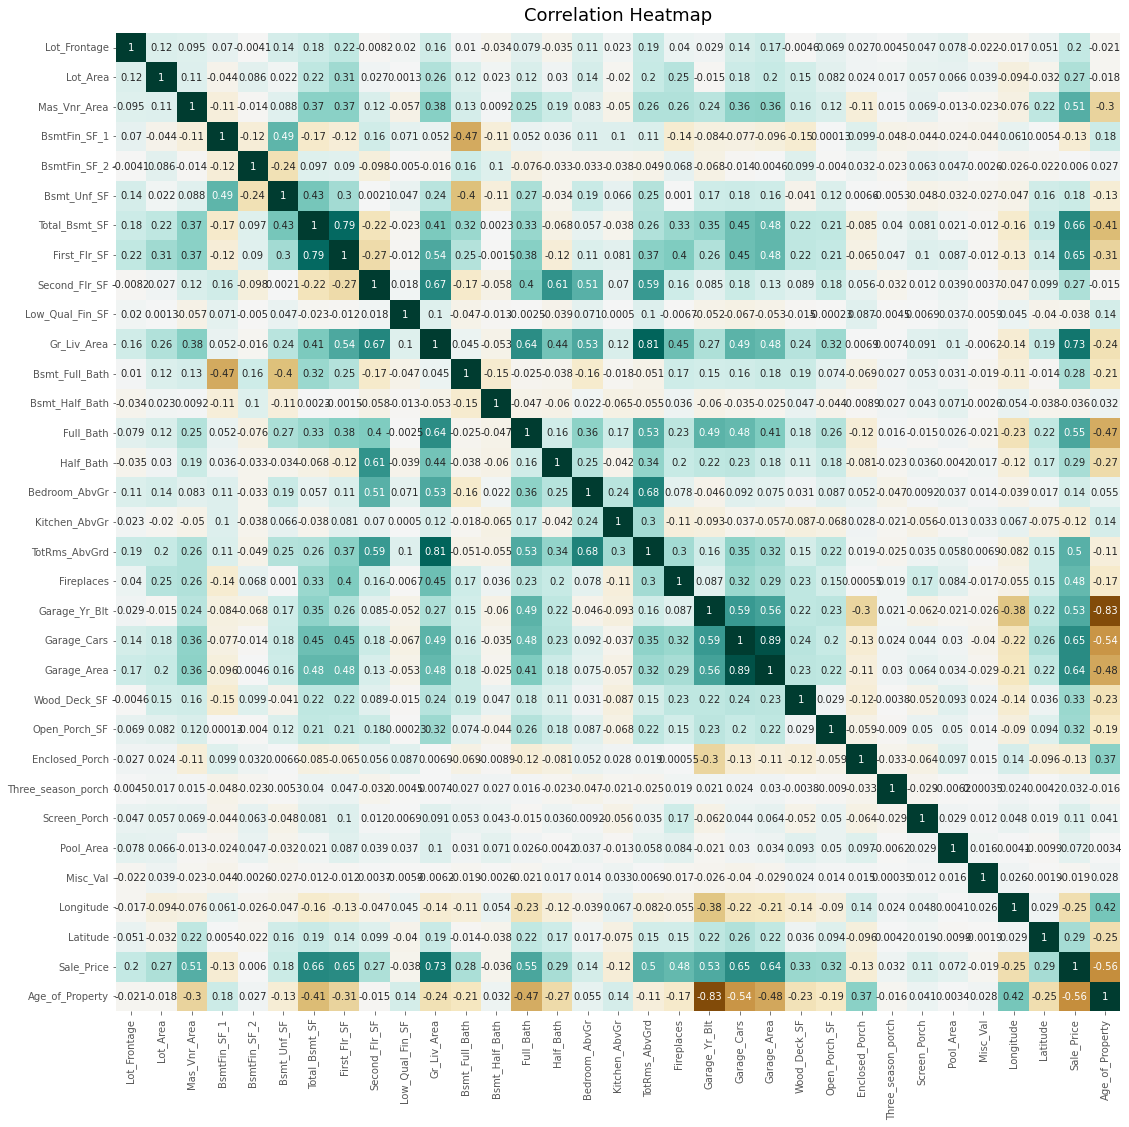

In [256]:
plt.figure(figsize=(18, 18))
heatmap = sns.heatmap(ames_num_cols_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

- Below columns can be removed which have either high correlation with one of the predictor or little to no correlation with target variable
    - Garage_Yr_Blt (has high correlation with year built)
    - 'Lot_Fontage', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unit_SF', 'Second_Flr_SF', 'Bsmt_Half_Bath', 'Half_Bath', 'Bedroom_AbvGrd', 'Enclosed_Porch', 'Three_season_porch', 'Screen_Porch', 'Pool_Area', 'Misc_Val', 'Mo_Sold', 'Year_Sold'

In [276]:
corr_df = ames_num_cols_df.corr()
corr_df_shortlisted = corr_df.loc[(corr_df['Sale_Price'] > 0.3) | (corr_df['Sale_Price'] < -0.3),:]
corr_df_shortlisted = corr_df_shortlisted.loc[:, corr_df_shortlisted.columns.isin(corr_df_shortlisted.index)]
corr_df_shortlisted = corr_df_shortlisted.loc[~corr_df_shortlisted.index.isin(['Garage_Yr_Blt']), ~corr_df_shortlisted.columns.isin(['Garage_Yr_Blt'])]
corr_df_shortlisted

,Mas_Vnr_Area,Total_Bsmt_SF,First_Flr_SF,Gr_Liv_Area,Full_Bath,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Sale_Price,Age_of_Property
Mas_Vnr_Area,1.000000,0.372250,0.369889,0.381326,0.251762,0.263727,0.263633,0.355387,0.361687,0.158023,0.117621,0.508375,-0.304898
Total_Bsmt_SF,0.372250,1.000000,0.785267,0.408140,0.329841,0.258950,0.325702,0.447951,0.477810,0.223708,0.214743,0.660810,-0.414839
First_Flr_SF,0.369889,0.785267,1.000000,0.535045,0.376081,0.372162,0.402221,0.446693,0.483615,0.218785,0.205792,0.645589,-0.312032
Gr_Liv_Area,0.381326,0.408140,0.535045,1.000000,0.638898,0.807220,0.451680,0.493425,0.475429,0.244085,0.316614,0.727122,-0.239554
Full_Bath,0.251762,0.329841,0.376081,0.638898,1.000000,0.528921,0.228717,0.476200,0.405618,0.178243,0.255261,0.546369,-0.468696
TotRms_AbvGrd,0.263727,0.258950,0.372162,0.807220,0.528921,1.000000,0.297282,0.353844,0.318679,0.147682,0.219032,0.500005,-0.108051
Fireplaces,0.263633,0.325702,0.402221,0.451680,0.228717,0.297282,1.000000,0.320991,0.288510,0.225306,0.151801,0.476386,-0.168660
Garage_Cars,0.355387,0.447951,0.446693,0.493425,0.476200,0.353844,0.320991,1.000000,0.892446,0.238712,0.200683,0.648141,-0.537419
Garage_Area,0.361687,0.477810,0.483615,0.475429,0.405618,0.318679,0.288510,0.892446,1.000000,0.233687,0.221729,0.644103,-0.479890
Wood_Deck_SF,0.158023,0.223708,0.218785,0.244085,0.178243,0.147682,0.225306,0.238712,0.233687,1.000000,0.028999,0.327985,-0.227457


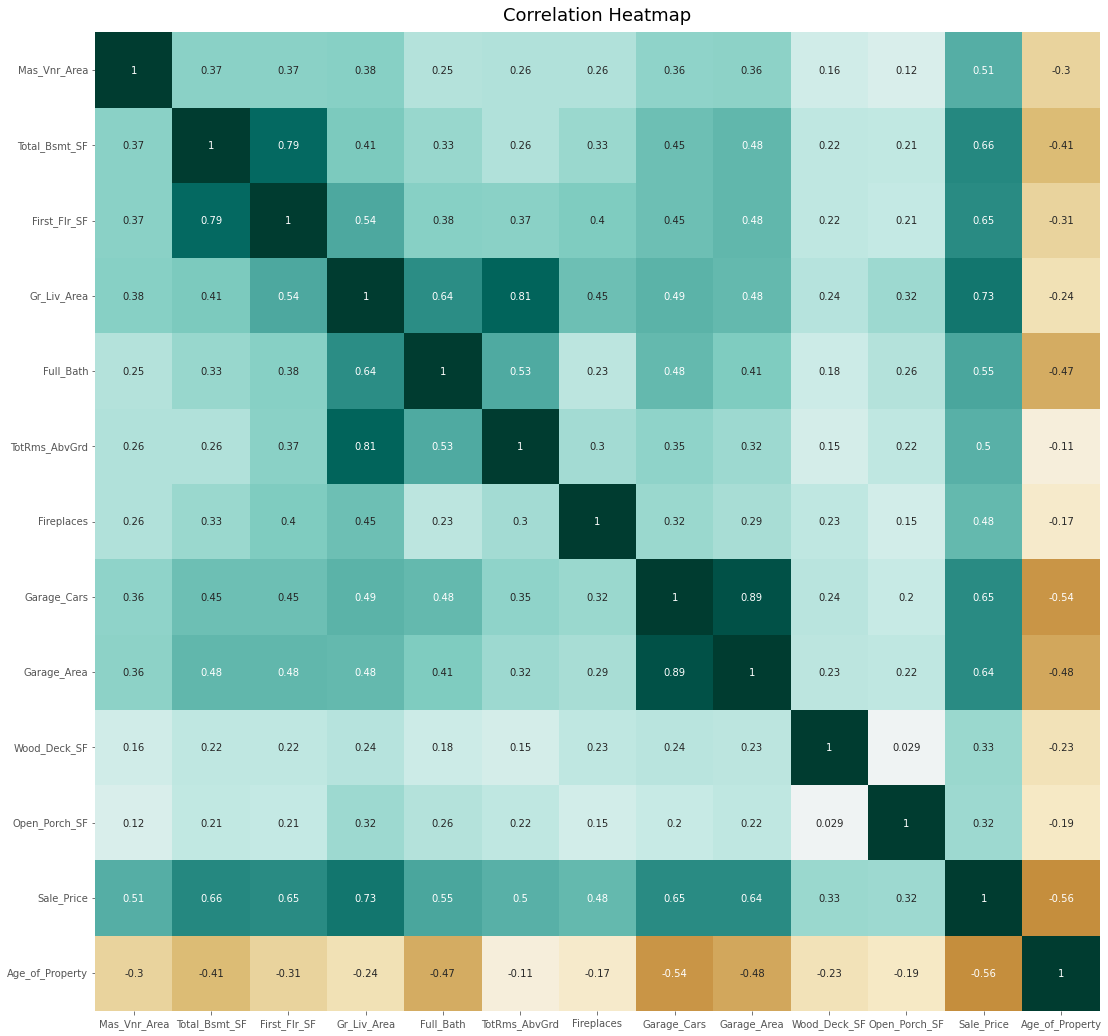

In [277]:
plt.figure(figsize=(18, 18))
heatmap = sns.heatmap(corr_df_shortlisted, vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Further we can remove below variables that are highly correlated with each other.
1. Garage_Area (r = 0.9 with Garage_Cars)
2. TotRms_AbvGrd (r = 0.8 with Gr_Liv_Area)
3. First_Flr_SF (r = 0.8 with Total_Bsmt_SF)

In [278]:
corr_df_shortlisted = corr_df_shortlisted.loc[~corr_df_shortlisted.index.isin(['Garage_Area', 'Garage_Area', 'First_Flr_SF']), ~corr_df_shortlisted.columns.isin(['Garage_Area', 'Garage_Area', 'First_Flr_SF'])]

In [279]:
corr_df_shortlisted

,Mas_Vnr_Area,Total_Bsmt_SF,Gr_Liv_Area,Full_Bath,TotRms_AbvGrd,Fireplaces,Garage_Cars,Wood_Deck_SF,Open_Porch_SF,Sale_Price,Age_of_Property
Mas_Vnr_Area,1.000000,0.372250,0.381326,0.251762,0.263727,0.263633,0.355387,0.158023,0.117621,0.508375,-0.304898
Total_Bsmt_SF,0.372250,1.000000,0.408140,0.329841,0.258950,0.325702,0.447951,0.223708,0.214743,0.660810,-0.414839
Gr_Liv_Area,0.381326,0.408140,1.000000,0.638898,0.807220,0.451680,0.493425,0.244085,0.316614,0.727122,-0.239554
Full_Bath,0.251762,0.329841,0.638898,1.000000,0.528921,0.228717,0.476200,0.178243,0.255261,0.546369,-0.468696
TotRms_AbvGrd,0.263727,0.258950,0.807220,0.528921,1.000000,0.297282,0.353844,0.147682,0.219032,0.500005,-0.108051
Fireplaces,0.263633,0.325702,0.451680,0.228717,0.297282,1.000000,0.320991,0.225306,0.151801,0.476386,-0.168660
Garage_Cars,0.355387,0.447951,0.493425,0.476200,0.353844,0.320991,1.000000,0.238712,0.200683,0.648141,-0.537419
Wood_Deck_SF,0.158023,0.223708,0.244085,0.178243,0.147682,0.225306,0.238712,1.000000,0.028999,0.327985,-0.227457
Open_Porch_SF,0.117621,0.214743,0.316614,0.255261,0.219032,0.151801,0.200683,0.028999,1.000000,0.317649,-0.194981
Sale_Price,0.508375,0.660810,0.727122,0.546369,0.500005,0.476386,0.648141,0.327985,0.317649,1.000000,-0.558918


Visualizing Lattitude and Longitude and sales price

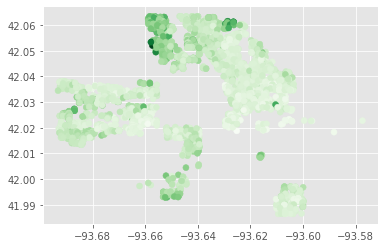

In [280]:
plt.scatter(ames_data.Longitude, ames_data.Latitude, c=ames_data.Sale_Price, cmap='Greens')
plt.show()

- We can see that there are some spots where prices are high, for most part, price is constant.

## <a id="#">3. Modeling</a>

In [281]:
selected_cat_col.extend(corr_df_shortlisted.columns)

In [282]:
ames_final = ames_data.loc[:, ames_data.columns.isin(selected_cat_col)]
ames_final.head()

,MS_SubClass,MS_Zoning,Neighborhood,Overall_Qual,Mas_Vnr_Area,Exter_Qual,Foundation,Bsmt_Qual,Bsmt_Exposure,Total_Bsmt_SF,...,Garage_Type,Garage_Finish,Garage_Cars,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Sale_Type,Sale_Condition,Sale_Price,Age_of_Property
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,North_Ames,Above_Average,112,Typical,CBlock,Typical,Gd,1080,...,Attchd,Fin,2,Partial_Pavement,210,62,WD,Normal,215000,50
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,North_Ames,Average,0,Typical,CBlock,Typical,No,882,...,Attchd,Unf,1,Paved,140,0,WD,Normal,105000,49
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,North_Ames,Above_Average,108,Typical,CBlock,Typical,No,1329,...,Attchd,Unf,1,Paved,393,36,WD,Normal,172000,52
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,North_Ames,Good,0,Good,CBlock,Typical,No,2110,...,Attchd,Fin,2,Paved,0,0,WD,Normal,244000,42
4,Two_Story_1946_and_Newer,Residential_Low_Density,Gilbert,Average,0,Typical,PConc,Good,No,928,...,Attchd,Fin,2,Paved,212,34,WD,Normal,189900,13


### <a id='3.3'> 3.2 XgBoost<a/>

In [283]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X = ames_final.loc[:, ~ames_final.columns.str.contains('Sale_Price')]
y = ames_final['Sale_Price']

In [284]:
for col in ames_final.columns:
    if ames_final[col].dtype == 'object':
        X[col] = lbl.fit_transform(X[col].astype(str))

In [285]:
ames_final.iloc[test_ids[0],:]

,MS_SubClass,MS_Zoning,Neighborhood,Overall_Qual,Mas_Vnr_Area,Exter_Qual,Foundation,Bsmt_Qual,Bsmt_Exposure,Total_Bsmt_SF,...,Garage_Type,Garage_Finish,Garage_Cars,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Sale_Type,Sale_Condition,Sale_Price,Age_of_Property
902,One_and_Half_Story_Finished_All_Ages,Residential_Low_Density,Edwards,Above_Average,0,Typical,BrkTil,Typical,Mn,684,...,Detchd,Unf,2,Paved,0,46,ConLI,Normal,110000,90
755,One_Story_1945_and_Older,Residential_Medium_Density,Iowa_DOT_and_Rail_Road,Below_Average,0,Typical,CBlock,Typical,No,780,...,Detchd,Unf,2,Paved,0,23,WD,Normal,103000,85
1619,Split_or_Multilevel,Residential_Low_Density,Gilbert,Above_Average,0,Typical,PConc,Good,No,384,...,BuiltIn,Fin,2,Paved,0,0,WD,Normal,161500,13
166,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,North_Ames,Average,0,Typical,CBlock,Typical,No,1175,...,Detchd,RFn,2,Paved,0,0,WD,Normal,148000,50
1371,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,Sawyer,Average,0,Good,CBlock,Typical,No,1046,...,Detchd,Unf,1,Paved,0,60,WD,Abnorml,124000,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,Two_Story_1946_and_Newer,Residential_Low_Density,Northwest_Ames,Average,263,Typical,CBlock,Typical,No,780,...,Attchd,Fin,2,Paved,208,0,WD,Normal,152000,41
1496,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,Edwards,Below_Average,0,Typical,PConc,Good,No,1132,...,Attchd,Fin,2,Paved,252,64,WD,Normal,176000,5
1779,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,Somerset,Very_Good,248,Good,PConc,Good,Mn,1524,...,Attchd,Fin,2,Paved,168,46,WD,Family,215000,4
96,Two_Story_PUD_1946_and_Newer,Floating_Village_Residential,Somerset,Good,0,Good,PConc,Good,No,600,...,Detchd,RFn,2,Paved,0,172,WD,Normal,151000,6


In [286]:
X_train = X.iloc[~X.index.isin(test_ids[0]),:]
X_test = X.iloc[X.index.isin(test_ids[0]),:]
y_train = ames_final.iloc[~ames_final.index.isin(test_ids[0]),:]['Sale_Price']
y_test = ames_final.iloc[ames_final.index.isin(test_ids[0]),:]['Sale_Price']

In [287]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [288]:
# set parameters for model
param = {'max_depth': 50, 'eta': 0.1, 'objective': 'reg:squarederror'}
param['nthread'] = 4
param['eval_metric'] = 'rmsle'

In [289]:
# Specify validations set to watch performance
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [290]:
num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmsle:2.32516	train-rmsle:2.31050
[1]	eval-rmsle:1.67358	train-rmsle:1.66383
[2]	eval-rmsle:1.31982	train-rmsle:1.31030
[3]	eval-rmsle:1.08368	train-rmsle:1.07290
[4]	eval-rmsle:0.91059	train-rmsle:0.89953
[5]	eval-rmsle:0.77815	train-rmsle:0.76599
[6]	eval-rmsle:0.67263	train-rmsle:0.65982
[7]	eval-rmsle:0.58709	train-rmsle:0.57320
[8]	eval-rmsle:0.51633	train-rmsle:0.50139
[9]	eval-rmsle:0.45864	train-rmsle:0.44126
[10]	eval-rmsle:0.40875	train-rmsle:0.39004
[11]	eval-rmsle:0.36696	train-rmsle:0.34616
[12]	eval-rmsle:0.33155	train-rmsle:0.30871
[13]	eval-rmsle:0.30246	train-rmsle:0.27606
[14]	eval-rmsle:0.27731	train-rmsle:0.24757
[15]	eval-rmsle:0.25596	train-rmsle:0.22257
[16]	eval-rmsle:0.23716	train-rmsle:0.20065
[17]	eval-rmsle:0.22206	train-rmsle:0.18130
[18]	eval-rmsle:0.20892	train-rmsle:0.16424
[19]	eval-rmsle:0.19799	train-rmsle:0.14910


In [291]:
ypred = bst.predict(dtest)

In [292]:
def calc_rmsle(ypred, ytest):
#     return np.sqrt(np.mean((ypred - ytest)**2))
    return np.sqrt(np.mean((np.log(ypred) - np.log(ytest))**2))
calc_rmsle(ypred, y_test)

0.19799533308554765

### Hyperparameters tuning

In [293]:
# Create a list of hyperparameters
# ref: https://stackoverflow.com/questions/12130883/r-expand-grid-function-in-python
from itertools import product

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

params = {
        'max_depth': [500],
        'eta': [0.1, 0.15, 0.2, 0.25],
        'min_child_weight': [5, 7],
        'gamma': [200, 2000, 10000],
        'subsample': [0.8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'objective': ['reg:squarederror'],
        'reg_alpha':[50, 100]
        }
params_df = expand_grid(params)

In [294]:
print(len(params_df))
params_df.head()

144


,max_depth,eta,min_child_weight,gamma,subsample,colsample_bytree,objective,reg_alpha
0,500,0.1,5,200,0.8,0.6,reg:squarederror,50
1,500,0.1,5,200,0.8,0.6,reg:squarederror,100
2,500,0.1,5,200,0.8,0.8,reg:squarederror,50
3,500,0.1,5,200,0.8,0.8,reg:squarederror,100
4,500,0.1,5,200,0.8,1.0,reg:squarederror,50


In [295]:
# ames_final.drop(['Central_Air', 'Paved_Drive', 'Electrical', 'Full_Bath', 'Exter_Qual', 'Foundation', 'Sale_Type'], axis=1, inplace=True)

In [296]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X = ames_final.loc[:, ~ames_final.columns.str.contains('Sale_Price')]
y = ames_final['Sale_Price']

In [297]:
for col in ames_final.columns:
    if ames_final[col].dtype == 'object':
        X[col] = lbl.fit_transform(X[col].astype(str))

In [298]:
X_train = X.iloc[~X.index.isin(test_ids[4]),:]
X_test = X.iloc[X.index.isin(test_ids[4]),:]
y_train = ames_final.iloc[~ames_final.index.isin(test_ids[4]),:]['Sale_Price']
y_test = ames_final.iloc[ames_final.index.isin(test_ids[4]),:]['Sale_Price']

In [299]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

<hr>

In [300]:
# from sklearn import preprocessing
# lbl = preprocessing.LabelEncoder()
# X = ames_data.loc[:, ~ames_data.columns.str.contains('Sale_Price')]
# y = ames_data['Sale_Price']

In [301]:
# for col in ames_data.columns:
#     if ames_data[col].dtype == 'object':
#         X[col] = lbl.fit_transform(X[col].astype(str))

In [302]:
# X_train = X.iloc[~X.index.isin(test_ids[0]),:]
# X_test = X.iloc[X.index.isin(test_ids[0]),:]
# y_train = ames_data.iloc[~ames_data.index.isin(test_ids[0]),:]['Sale_Price']
# y_test = ames_data.iloc[ames_data.index.isin(test_ids[0]),:]['Sale_Price']

In [303]:
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

<hr>

In [304]:
rmsles = {}
for num in [60]:
    for idx in params_df.index:
        param = params_df.iloc[idx,:].to_dict()
        param['nthread'] = 4
        param['eval_metric'] = 'rmsle'
        evallist = [(dtest, 'eval'), (dtrain, 'train')]
        num_round = num
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
        ypred = bst.predict(dtest)
        rmsle = calc_rmsle(ypred, y_test)
        rmsles.update({rmsle:param})

In [305]:
print(min(rmsles.keys()))
rmsles[min(rmsles.keys())]

0.14050461347993357


{'max_depth': 500,
 'eta': 0.1,
 'min_child_weight': 5,
 'gamma': 10000,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'reg_alpha': 100,
 'nthread': 4,
 'eval_metric': 'rmsle'}

In [1382]:
print(min(rmsles.keys()))
rmsles[min(rmsles.keys())]

0.1396882759151403


{'max_depth': 500,
 'eta': 0.1,
 'min_child_weight': 5,
 'gamma': 2000,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'reg_alpha': 50,
 'nthread': 4,
 'eval_metric': 'rmsle'}

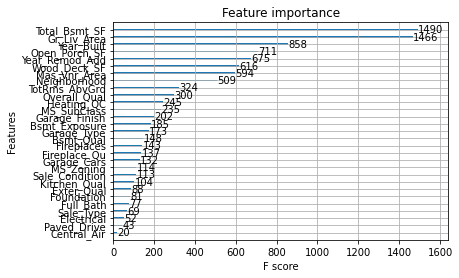

In [1383]:
xgb.plot_importance(bst)
plt.show()

In [1178]:
print(min(rmsles.keys()))
rmsles[min(rmsles.keys())]

0.12306065865657737


{'max_depth': 500,
 'eta': 0.1,
 'gamma': 2000,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'objective': 'reg:squarederror',
 'reg_alpha': 50,
 'nthread': 4,
 'eval_metric': 'rmsle'}

In [306]:
param = rmsles[min(rmsles.keys())]
param['nthread'] = 4
param['eval_metric'] = 'rmsle'

num_round = num

for idx in range(10):
    X_train = X.iloc[~X.index.isin(test_ids[idx]),:]
    X_test = X.iloc[X.index.isin(test_ids[idx]),:]
    
    y_train = ames_final.iloc[~ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    y_test = ames_final.iloc[ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
    dtest = xgb.DMatrix(X_test, label=y_test)
    ypred = bst.predict(dtest)
    rmsle = calc_rmsle(ypred, y_test)
    print(rmsle)

0.14385056789002149
0.12281058031816412
0.13510311301020464
0.1411133971167967
0.14050461347993357
0.14322105284542352
0.12386641694333375
0.13702765661771393
0.13588196823355328
0.14496621860493686


In [61]:
param = rmsles[min(rmsles.keys())]
param['nthread'] = 4
param['eval_metric'] = 'rmsle'

num_round = num

for idx in range(10):
    X_train = X.iloc[~X.index.isin(test_ids[idx]),:]
    X_test = X.iloc[X.index.isin(test_ids[idx]),:]
    
    y_train = ames_final.iloc[~ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    y_test = ames_final.iloc[ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)
    dtest = xgb.DMatrix(X_test, label=y_test)
    ypred = bst.predict(dtest)
    rmsle = calc_rmsle(ypred, y_test)
    print(rmsle)

0.1399877734943408
0.12215481233260704
0.13167565743731915
0.1368734677753473
0.13968827591514027
0.13939275818054983
0.12209240136767437
0.13200646449636455
0.1380713299172648
0.14247489459658497


In [1170]:
param = rmsles[min(rmsles.keys())]
param['nthread'] = 4
param['eval_metric'] = 'rmsle'
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = num
        
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)

for idx in range(10):
    X_train = X.iloc[~X.index.isin(test_ids[idx]),:]
    X_test = X.iloc[X.index.isin(test_ids[idx]),:]
    
    y_train = ames_final.iloc[~ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    y_test = ames_final.iloc[ames_final.index.isin(test_ids[idx]),:]['Sale_Price']
    
    dtest = xgb.DMatrix(X_test, label=y_test)
    ypred = bst.predict(dtest)
    rmsle = calc_rmsle(ypred, y_test)
    print(rmsle)
print(param)

0.13414919463817943
0.06699064093408942
0.07647631995021398
0.07774106173146944
0.0824890691805489
0.13409137789953104
0.06699075736099468
0.07609012130309704
0.07774113646527088
0.08248894204131507
{'max_depth': 500, 'eta': 0.15, 'gamma': 200, 'subsample': 0.8, 'colsample_bytree': 0.6, 'objective': 'reg:squarederror', 'reg_alpha': 100, 'nthread': 4, 'eval_metric': 'rmsle'}


### <a id='3.3'> 3.2 Linear Models<a/>

In [111]:
# mu, sigma = norm.fit(ames_final['Sale_Price'])
# # print(f'Mean: {mu}, Sigma:{sigma}')

# # plot distribution
# sns.distplot(ames_final['Sale_Price'] , fit=norm);
# plt.legend([f'Mean: {round(mu, 2)}, Sigma:{round(sigma, 2)}'], loc='best')

# plt.ylabel('Frequency')
# plt.title('Sale_Price distribution')

# # QQ-plot
# fig = plt.figure()
# stats.probplot(ames_final['Sale_Price'], dist='norm', plot=pylab)
# pylab.show()

# stat, p = shapiro(ames_final['Sale_Price'])
# print(stat, p)

In [121]:
new_x_trn = X_train.loc[:, ~X_train.columns.isin(categorical_vars['column'])]
new_x_trn.drop(['Year_Built', 'Year_Remod_Add'], axis =1, inplace=True)

In [122]:
new_x_trn

,Mas_Vnr_Area,Total_Bsmt_SF,Gr_Liv_Area,Full_Bath,TotRms_AbvGrd,Fireplaces,Garage_Cars,Wood_Deck_SF,Open_Porch_SF
0,112,1080,1656,1,7,2,2,210,62
2,108,1329,1329,1,6,0,1,393,36
3,0,2110,2110,2,8,2,2,0,0
5,20,926,1604,2,7,1,2,360,36
6,0,1338,1338,2,6,0,2,0,0
...,...,...,...,...,...,...,...,...,...
2925,0,1003,1003,1,6,0,2,120,0
2926,0,864,902,1,5,0,2,164,0
2927,0,912,970,1,6,0,0,80,32
2928,0,1389,1389,1,6,1,2,240,38


In [62]:
X_train

,MS_SubClass,MS_Zoning,Neighborhood,Overall_Qual,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Foundation,Bsmt_Qual,...,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Finish,Garage_Cars,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Sale_Type,Sale_Condition
0,2,5,15,0,1960,1960,112,3,1,5,...,2,2,0,0,2,1,210,62,9,4
1,2,4,15,1,1961,1961,0,3,1,5,...,0,3,0,3,1,2,140,0,9,4
3,2,5,15,5,1968,1968,0,2,1,5,...,2,5,0,0,2,2,0,0,9,4
5,13,5,8,0,1998,1998,20,3,2,5,...,1,2,0,0,2,2,360,36,9,4
6,3,5,25,8,2001,2001,0,2,2,2,...,0,3,0,0,2,2,0,0,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,0,5,14,1,1976,1976,0,3,1,5,...,0,3,4,3,2,2,0,0,9,3
2923,2,5,14,1,1977,1977,0,3,1,5,...,1,2,0,2,2,1,295,41,9,4
2924,2,5,14,1,1960,1996,0,3,1,5,...,1,5,4,3,2,2,474,0,9,0
2925,10,5,14,0,1984,1984,0,3,1,5,...,0,3,4,3,2,2,120,0,9,4


In [129]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn import metrics, linear_model

ols = LinearRegression()
ols.fit(X_train, y_train)

print("Intercept:", ols.intercept_)
print("Coefficients:", ols.coef_)

Intercept: -583657.4164933842
Coefficients: [  -396.01088917   -402.16778551     70.67377299    732.67426525
    121.01634469    222.92088918     39.5070494  -15312.41265688
   1889.56504369  -3236.33133494  -4039.44054019     35.68797118
   -629.84111101  10196.85727234   -275.00279055     77.34977421
 -10679.69115615  -5669.00913605  -3371.55041612   8616.40780515
  -2309.49574704     12.90753806  -2075.84426997   8267.57226715
   5070.57983653     22.26118363      1.07113384   -300.46537567
   3451.86324119]


In [87]:
# Function for scoring training set
def train_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (train set)
    y: Dependant variable (train set)
    '''
    cv_scores = cross_val_score(model, X, y, cv=5) # 5-fold cross-validation

    print('Training Score:', np.round(model.score(X, y), 4))
    print('Cross-validation scores:', np.round(cv_scores, 4))
    print('Mean cross-validation score:', np.round(cv_scores.mean(), 4))

In [88]:
# Function for scoring test set
def test_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    print('Test Score:', np.round(model.score(X, y), 4))

In [109]:
# Function for MSE & RMSE scoring
def accuracy_scores(model, X, y):
    '''
    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    yhat = model.predict(X)
    print('Mean Squared Error:', np.round(metrics.mean_squared_error(y, yhat), 4)) 
    print('Root Mean Squared Error:', np.round((metrics.mean_squared_error(y, yhat))**0.5, 4))
    print('Root Mean Log Squared Error:', np.round((metrics.mean_squared_log_error(y, yhat))**0.5, 4))

In [90]:
# Function for plotting histogram of residuals
def resid_histogram(model, X, y, period=''):
    '''
    model: fitted model
    X: Matrix of explanatory variables
    y: Dependant variable
    period: String describing data coverage period
    '''

    yhat = model.predict(X)
    residuals = y - yhat

    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(residuals, bins=50, kde=True, ax=ax)
    plt.title(f'OLS Residuals, {period}', fontsize=18);

In [91]:
train_scores(ols, X_train, y_train)

Training Score: 0.8582
Cross-validation scores: [0.8603 0.8533 0.8509 0.8389 0.8353]
Mean cross-validation score: 0.8477


In [92]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_shuffled = cross_val_score(ols, X_train, y_train, cv=kf)

In [93]:
test_scores(ols, X_test, y_test)

Test Score: 0.8513


In [110]:
accuracy_scores(ols, X_test, y_test)

Mean Squared Error: 892820703.4121
Root Mean Squared Error: 29880.1055
Root Mean Log Squared Error: 0.1929


In [126]:
new_x_tst = X_test.loc[:, ~X_test.columns.isin(categorical_vars['column'])]
new_x_tst.drop(['Year_Built', 'Year_Remod_Add'], axis =1, inplace=True)

In [130]:
pred = ols.predict(X_test)

In [131]:
calc_rmsle(pred, y_test)

0.19290273777100758

#### Ridge & Lasso regressions

In [132]:
# Ridge Cross-Validation
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)

print('Best Ridge alpha:', ridge_mod.alpha_)

Best Ridge alpha: 21.54434690031882


In [133]:
# Ridge training set scores, including CV scores
train_scores(ridge_mod, X_train, y_train)

Training Score: 0.8581
Cross-validation scores: [0.8595 0.854  0.851  0.8388 0.8364]
Mean cross-validation score: 0.8479


In [134]:
# Ridge test set score
test_scores(ridge_mod, X_test, y_test)

Test Score: 0.8513


In [135]:
# Confirmed similar to the above Ridge CV scores
ridge_mod = Ridge(alpha=21.544)

ridge_mod.fit(X_train, y_train)
print("Training Score:", round(ridge_mod.score(X_train, y_train), 4))
print("Test Score:", round(ridge_mod.score(X_test, y_test), 4))

Training Score: 0.8581
Test Score: 0.8513


In [136]:
# Ridge MSE & RMSE scores
accuracy_scores(ridge_mod, X_test, y_test)

Mean Squared Error: 892995326.8978
Root Mean Squared Error: 29883.0274
Root Mean Log Squared Error: 0.1911


<hr>

In [137]:
# Lasso Cross-Validation
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)

Best Lasso alpha: 166.81005372000558


In [138]:
# Lasso training set scores, including CV scores
train_scores(lasso_mod, X_train, y_train)

Training Score: 0.8579
Cross-validation scores: [0.8597 0.8543 0.8507 0.8388 0.8367]
Mean cross-validation score: 0.848


In [139]:
# Lasso test set score
test_scores(lasso_mod, X_test, y_test)

Test Score: 0.8512


In [140]:
# Lasso MSE & RMSE scores
accuracy_scores(lasso_mod, X_test, y_test)

Mean Squared Error: 893408569.0557
Root Mean Squared Error: 29889.9409
Root Mean Log Squared Error: 0.1893


In [141]:
X_test.columns

Index(['MS_SubClass', 'MS_Zoning', 'Neighborhood', 'Overall_Qual',
       'Year_Built', 'Year_Remod_Add', 'Mas_Vnr_Area', 'Exter_Qual',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Exposure', 'Total_Bsmt_SF',
       'Heating_QC', 'Central_Air', 'Electrical', 'Gr_Liv_Area', 'Full_Bath',
       'Kitchen_Qual', 'TotRms_AbvGrd', 'Fireplaces', 'Fireplace_Qu',
       'Garage_Type', 'Garage_Finish', 'Garage_Cars', 'Paved_Drive',
       'Wood_Deck_SF', 'Open_Porch_SF', 'Sale_Type', 'Sale_Condition'],
      dtype='object')

In [1164]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [1165]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_log_error", cv = kf))
    return(rmse)

In [1166]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=100, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = 4)

In [1167]:
score = rmsle_cv(model_xgb)

In [1168]:
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1364 (0.0080)



## <a id = 'data_dict'>Data Dictionary<a/>
    
- Below is the data dictionary
    - PID: the Parcel identification number
    - SalePrice: the property's sale price in dollars. This is the target variable that you're trying to predict.
    - MSSubClass: The building class
    - MSZoning: The general zoning classification
    - LotFrontage: Linear feet of street connected to property
    -  LotArea: Lot size in square feet
    - Street: Type of road access
    -   Alley: Type of alley access
    -   LotShape: General shape of property
    - LandContour: Flatness of the property
    - Utilities: Type of utilities available
    -   LotConfig: Lot configuration
    - LandSlope: Slope of property
    - Neighborhood: Physical locations within Ames city limits
    -   Condition1: Proximity to main road or railroad
    -   Condition2: Proximity to main road or railroad (if a second is present)
    -  BldgType: Type of dwelling
    -   HouseStyle: Style of dwelling
    -  OverallCond: Overall condition rating
    -   YearBuilt: Original construction date
    -   YearRemodAdd: Remodel date
    -   RoofStyle: Type of roof
    -   RoofMatl: Roof material
    -   Exterior1st: Exterior covering on house
    -   MasVnrArea: Masonry veneer area in square feet
    -     ExterQual: Exterior material quality
    -    ExterCond: Present condition of the material on the exterior
    - BsmtQual: Height of the basement
    -    BsmtCond: General condition of the basement
    -   BsmtExposure: Walkout or garden level basement walls
    -    BsmtFinType1: Quality of basement finished area
    -    BsmtFinSF1: Type 1 finished square feet
    -    BsmtFinType2: Quality of second finished area (if present)
    -    BsmtFinSF2: Type 2 finished square feet
    -    BsmtUnfSF: Unfinished square feet of basement area
    -    TotalBsmtSF: Total square feet of basement area
    -   Heating: Type of heating
    -   HeatingQC: Heating quality and condition
    -   CentralAir: Central air conditioning
    -   Electrical: Electrical system
    -    1stFlrSF: First Floor square feet
    -    2ndFlrSF: Second floor square feet
    -    LowQualFinSF: Low quality finished square feet (all floors)
    -    GrLivArea: Above grade (ground) living area square feet
    -    BsmtFullBath: Basement full bathrooms
    -    BsmtHalfBath: Basement half bathrooms
    -    FullBath: Full bathrooms above grade
    -    HalfBath: Half baths above grade
    -    Bedroom: Number of bedrooms above basement level
    -    Kitchen: Number of kitchens
    -    KitchenQual: Kitchen quality
    -   TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    -    Functional: Home functionality rating
    - FireplaceQu: Fireplace quality
    -  GarageType: Garage location
    - GarageYrBlt: Year garage was built
    -  GarageFinish: Interior finish of the garage
    -   GarageCars: Size of garage in car capacity
    -    GarageArea: Size of garage in square feet
    -   GarageQual: Garage quality
    -   GarageCond: Garage condition
    -   PavedDrive: Paved driveway
    -   WoodDeckSF: Wood deck area in square feet
    -   OpenPorchSF: Open porch area in square feet
    - EnclosedPorch: Enclosed porch area in square feet
    -   3SsnPorch: Three season porch area in square feet
    -   ScreenPorch: Screen porch area in square feet
    -   PoolArea: Pool area in square feet
    -   PoolQC: Pool quality
    -   Fence: Fence quality
    -   MiscFeature: Miscellaneous feature not covered in other categories
    -   MiscVal: $Value of miscellaneous feature
    -   MoSold: Month Sold
    -   YrSold: Year Sold
    -   SaleType: Type of sale
    -   SaleCondition: Condition of sale